## Denoising Diffusion Probabilistic Models (DDPM)


### (1) Forward Diffusion Process
Given a data-point $x_0$ sampled from the real data distribution $q(x)$ ($x_0 \sim q(x)$), one can define a forward diffusion process by adding noise. Specifically, at each step of the Markov chain we add Gaussian noise with variance $\beta_t$ to $x_{t-1}$, producing a new latent variable $x_t$ with distribution $q(x_t|x_{t-1})$.


**Noise Sampling** </br>
This diffusion process for sampling noise can be formulated as follows:

$$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \mu_t = \sqrt{1-\beta_t}x_{t-1}, \Sigma_t = \beta_t I)$$

This defines a conditional Gaussian distribution with $\beta_t$ as a variance schedule which describes how much noise should be added at each timestep. A larger $\beta$ means the pixel distribution is wider but also more shifted which results in a more corrupted (noisier) image. The noise scheduler allows to add the right amount of noise to end up in an Isotropic Gaussian. Since the sum of Gaussians is still a Gaussian distribution multiple noise steps can be pre-computed as a Kernel for a specific timestep $t$ and don't need to iteratively over its predecessors. For this we need to precalculate the closed form of the mean and variance based on accumulative variance schedules.

#### Noise Scheduler

The variance schedule $\beta_t$ determines the amount of noise added at each timestep. A larger $\beta_t$ results in a wider pixel distribution and a more corrupted (noisier) image.

Key terms:

- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ (the accumulated product)

The closed form of the forward process can be expressed as:

$$q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)I)$$

This allows us to sample $x_t$ directly for any arbitrary timestep $t$ without having to sample all intermediate steps.

The forward process can be reparameterized as:

$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$$

where $\epsilon \sim \mathcal{N}(0, I)$.

#### Variance Schedule Design

The choice of variance schedule is crucial for the model's performance. Common choices include:

1. Linear schedule:
   $$\beta_t = \beta_1 + \frac{t-1}{T-1}(\beta_T - \beta_1)$$

2. Cosine schedule:
   $$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \text{ where } f(t) = \cos\left(\frac{t/T + s}{1 + s}\cdot\frac{\pi}{2}\right)^2$$
   
   Here, $s$ is a small offset to prevent $\bar{\alpha}_t$ from becoming too small.

### 2. Parametrized Backward Denoising Process

The backward process aims to gradually denoise the data by learning the reverse transitions. It is parameterized by a neural network $\epsilon_\theta(x_t, t)$ that predicts the noise added during the forward process.

The backward process can be described as:

$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

Where:

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right)$$

$$\sigma_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t$$

The objective is to minimize the difference between the predicted noise and the actual noise added during the forward process:

$$L = \mathbb{E}_{t,x_0,\epsilon}\left[\|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t)\|^2\right]$$

During inference, we can sample from the model by starting with pure noise $x_T \sim \mathcal{N}(0, I)$ and iteratively applying the learned reverse process:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right) + \sigma_t z$$

Where $z \sim \mathcal{N}(0, I)$.

This expanded description includes the key formulas for the noise scheduler, variance schedule designs, and the backward denoising process. It provides a more comprehensive mathematical foundation for understanding DDPMs. Would you like me to elaborate on any specific part or add more details to any section?

In [70]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, sampler, random_split

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

In [71]:
# Hyperparameters
conf = {
    'img_size': 64,
    'batch_size': 128,
    'timesteps': 300,
}

# Folder paths
data_path = 'data/'
model_path = 'models/'
results_path = 'results/'
log_path = 'logs/'

# Create folders

os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

# Random seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Torch Dataset

In [72]:
celeb_transforms = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.RandomHorizontalFlip(),
    T.ToTensor(), # Scales to [0, 1]
    T.Lambda(lambda x: x*2.0 - 1.0), # Scale to [-1, 1]
])

dataset = datasets.CIFAR10(data_path, download=True, transform=celeb_transforms)
dataloader = DataLoader(dataset, batch_size=conf['batch_size'], shuffle=True, drop_last=True)

Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

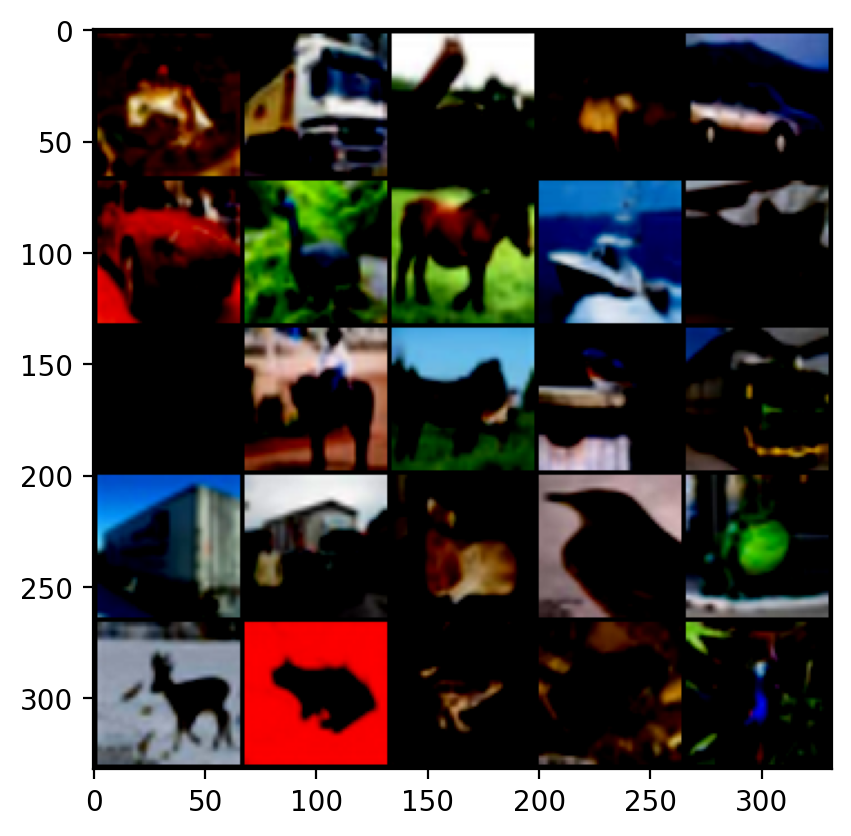

In [73]:
# Plot samples
samples = [dataset[i][0] for i in range(25)]
grid = torchvision.utils.make_grid(samples, nrow=5)
grid = grid.permute(1,2,0).numpy()
plt.savefig(f'{results_path}celeb_samples.png')
plt.figure(dpi=200)
plt.imshow(grid)

## Utility Functions

In [74]:
def show_tensor_image(img):
    reverse_transform = T.Compose([
        T.Lambda(lambda x: (x+1.0)/2.0), # Scale to [0, 1]
        T.Lambda(lambda x: x.permute(1,2,0)), # CHW to HWC
        T.Lambda(lambda x: x * 255), # To [0, 255]
        T.Lambda(lambda x: x.cpu().detach().numpy().astype(np.uint8)), # To numpy
        T.ToPILImage()
    ])

    # batch of images
    if len(img.shape) == 4:
        img = img[0, :, :, :]

    img = reverse_transform(img)
    plt.imshow(img)

In [75]:
## Noise Scheduler

def linear_beta_scheduler(timesteps, start=1e-4, end=2e-2, device='cpu'):
    return torch.linspace(start, end, timesteps, device=device)

def cosine_beta_scheduler(timesteps, s=0.008, device='cpu'):
  """ Based on: https://www.zainnasir.com/blog/cosine-beta-schedule-for-denoising-diffusion-models/"""

  t = timesteps

  def f(t):
    return torch.cos((t / timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2

  x = torch.linspace(0, t, timesteps + 1, device=device)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999) # avoid numerical instability
  return betas

def get_index_from_list(vals, t, x_shape):
    """ Returns a specific index t of a passed list of values,
        while considering the batch dimension.
    """
    device = vals.device
    t = t.to(device)

    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    # creates a tuple of 1s with length equal to #dimensions of x
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def sample_forward_diffusion(x_0, t, timesteps=300, linear=False, device=None):
    """
    Takes an image and a timestep as input and returns a perturbed noisy image of it.
    """
    if not device:
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x_0 = x_0.to(device)
    t = t.to(device)

    # Sample noise
    noise = torch.randn_like(x_0, device=device)

    if not linear:
      # cosine scheduler of DDPM paper
      betas = cosine_beta_scheduler(timesteps=timesteps, device=device)
    else:
      betas = linear_beta_scheduler(timesteps=timesteps, device=device)

    # Precalculate
    alphas = 1. - betas
    alphas_cum_prod = torch.cumprod(alphas, 0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cum_prod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cum_prod)

    # Compute new noisy sample
    # x_t = sqrt(beta_t) * x_0 + sqrt(1 - beta_t) * noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_prod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    xt = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_prod_t * noise

    return xt, noise

## Simulate Forward Diffusion

<ipython-input-76-51064818b7db>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, (idx // stepsize) + 1)


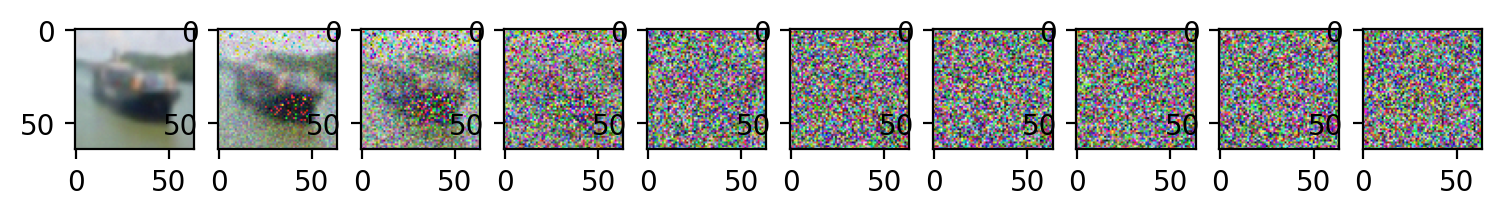

In [76]:
img = next(iter(dataloader))[0]

# Plot the original image
plt.figure(figsize=(10,1), dpi=200)
plt.title('Forward Diffusion Process')
plt.axis('off')
num_images = 10
stepsize = int(conf['timesteps'] / num_images)

for idx in range(0, conf['timesteps'], stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1)
    img, noise = sample_forward_diffusion(img, t, conf['timesteps'], device=device)
    show_tensor_image(img)

## Parametrized Backward Process

* model learns the probability of an earlier timestep given the current timestep
* during sampling we ues pure noies

### Timestep encoding

The timestep encoding is a simple positional encoding that is added to the input image at each timestep.
They can be visualized as a sine wave that is added to the image at each timestep.

In [77]:
class SinusoidalPositionEmbeddings(nn.Module):
    """ Create positional embeddings. """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

## Neural Network: U-Net Backbone

In [78]:
# Variance is fixed, only output one value per pixel
# Model learns to predict mean of Gaussian of the images (Denoising Score Matching)

class Block(nn.Module):
    """ Defines a Convolutional Block for Encoder/Decoder part of the U-Net network."""

    def __init__(self, in_channel, out_channel, t_embedding_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(t_embedding_dim, out_channel)
        if up:
            self.conv1 = nn.Conv2d(2*in_channel, out_channel, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channel, out_channel, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
            self.transform = nn.Conv2d(out_channel, out_channel, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channel)
        self.bnorm2 = nn.BatchNorm2d(out_channel)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Add time embedding
        time_emb = self.relu(self.time_mlp(t))
        # To match extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Upsample / std. conv
        h = self.transform(h)
        return h

class BaseUnet(nn.Module):#
    """ Simple U-Net Model implementation """
    def __init__(self, in_channels=3, out_channels=3, t_embed_dim=32):
        super(BaseUnet, self).__init__()

        encoder_channels = (64, 128, 256, 512, 1024)
        decoder_channels = (1024, 512, 256, 128, 64)

        # Time embedding as positional vector (based on sine/cosine func.)
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.ReLU()
        )

        # ---- Encoder ----
        self.conv0 = nn.Conv2d(in_channels, encoder_channels[0], kernel_size=(3, 3), padding=1)
        self.downsample = nn.ModuleList([Block(encoder_channels[i], encoder_channels[i+1], t_embed_dim, up=False) \
                                         for i in range(len(encoder_channels) - 1)])
        # ---- Decoder ----
        self.upsample = nn.ModuleList([Block(decoder_channels[i], decoder_channels[i+1], t_embed_dim, up=True) \
                                       for i in range(len(decoder_channels) - 1)])
        self.output = nn.Conv2d(decoder_channels[-1], out_channels, kernel_size=(3, 3), padding=1) # Read out

    def forward(self, x, timesteps):
        t = self.time_mlp(timesteps)
        x = self.conv0(x)

        # U-Net + Skip connections
        residuals = []                          # storing the activations as residuals from downsampling steps
        for down in self.downsample:
            x = down(x, t)
            residuals.append(x)

        for up in self.upsample:
            residual_x = residuals.pop()
            # Add residuals to x
            x = torch.cat([x, residual_x], dim=1)
            x = up(x, t)

        x = self.output(x)
        return x

    def print_parameters(self, name):
        num_params = 0
        for p in self.parameters():
            num_params += p.numel()

        print("{} has {:.3f}M parameters".format(name, num_params/1e6))

In [79]:
model = BaseUnet()
model.print_parameters(name='U-Net')

model.to(device)

U-Net has 62.440M parameters


BaseUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsample): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (trans

### Loss Function
* calculate L2 distance of predicted and actual noise of the image

In [80]:
def get_L2loss(model, x_0, t, device):
    # Set on device
    t = t.to(device)
    x_0 = x_0.to(device)

    x_noisy, noise = sample_forward_diffusion(x_0, t, device=device)
    noise_pred = model(x_noisy, t)

    # check sizes
    assert noise_pred.shape == noise.shape, "Predictions and targets must have the same shape"

    sqared_diff = (noise - noise_pred) ** 2
    loss = torch.mean(sqared_diff)
    return loss

In [81]:
# Precalculate the square roots of alphas and 1 - alphas
betas = linear_beta_scheduler(timesteps=conf['timesteps'], device=device)
alphas = 1. - betas

# Compute precalculations
alphas_cum_prod = torch.cumprod(alphas, 0)
alphas_cum_prod_prev = F.pad(alphas_cum_prod[:-1], (1, 0), value=1.)
sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cum_prod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cum_prod)
posterior_variance = betas * (1. - alphas_cum_prod_prev) / (1. - alphas_cum_prod)

### Sampling
* Needs adding of @torch.no_grad() decorator, since without, Pytoch tacks all images for gradient calculations
* Pre-calculate the noise variances for the forward pass

In [82]:
@torch.no_grad()
def sample_timestep(x, t, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    # Move all to device
    device = x.device
    t = t.to(device)
    betas = betas.to(device)
    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
    sqrt_recip_alphas = sqrt_recip_alphas.to(device)
    posterior_variance = posterior_variance.to(device)

    betas_t = get_index_from_list(betas, t, x.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    ).to(device)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape).to(device)

    # Make prediction
    pred_img = model(x, t)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * pred_img / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape).to(device)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x, device=device)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance):
    # Sample noise
    T = conf['timesteps']
    img_size = conf['img_size']

    # random noise
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training DDPM

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      # Select random timestep
      t = torch.randint(0, conf['timesteps'], (conf['batch_size'],), device=device).long()
      # Compute loss
      loss = get_L2loss(model, batch[0], t, device=device)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image(betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, posterior_variance)

## Resources

1. Denoising Diffusion Probabilistic Models
2. Diffusion Models Beat GANs on Image Synthesis
3. T. Chen, "Diffusion Models: DDPMs, DDIMs, and Classifier-Free Guidance," Better Programming, 2024. [Online]. Available: https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869. [Accessed: Jul. 20, 2024].

4. AI Summer, "Diffusion Models," The AI Summer. [Online]. Available: https://theaisummer.com/diffusion-models/. [Accessed: Jul. 20, 2024].